In [26]:
from datasets import load_from_disk
import matplotlib.pyplot as plt
import os

def plot_token_length_hist(dataset_path, tokenizer, min_length=0,
                           text_field="text", bins=100,
                           save_batch_size=None, save_dir=None):
    ds = load_from_disk(dataset_path)

    # Compute token lengths
    def _token_len(batch):
        enc = tokenizer(batch[text_field], add_special_tokens=False)
        return {"length": [len(ids) for ids in enc["input_ids"]]}

    ds = ds.map(
        _token_len,
        batched=True,
        num_proc=1,
        load_from_cache_file=False,
        keep_in_memory=True,
    )

    # Filter by minimum token length
    if min_length > 0:
        ds = ds.filter(lambda x: x["length"] >= min_length)

    lengths = ds["length"]
    print(f"number of documents ≥ {min_length} tokens: {len(lengths)}")

    # ---- SAVE FIRST BATCH ----
    if save_batch_size is not None and save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
        subset = ds.select(range(min(save_batch_size, len(ds))))
        subset.save_to_disk(save_dir)
        print(f"Saved {len(subset)} documents to: {save_dir}")

    # ---- PLOT ----
    plt.figure(figsize=(8,5))
    plt.hist(lengths, bins=bins)
    plt.xlabel("Document length (tokens)")
    plt.ylabel("Count")
    plt.title(f"C4 token-length histogram (min length = {min_length})")
    plt.tight_layout()
    plt.show()


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2557 > 1024). Running this sequence through the model will result in indexing errors


Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

number of documents ≥ 512 tokens: 78


Saving the dataset (0/1 shards):   0%|          | 0/64 [00:00<?, ? examples/s]

Saved 64 documents to: ../data_long_ctx


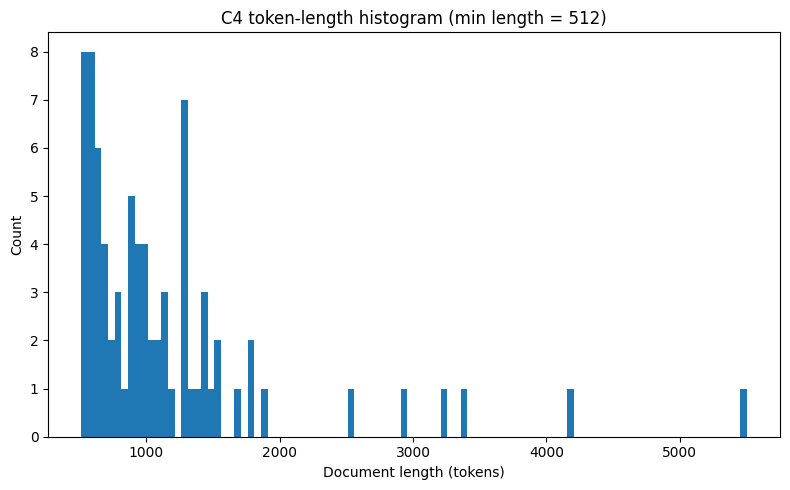

In [32]:
# Example usage:

from transformers import AutoTokenizer

tok = AutoTokenizer.from_pretrained("gpt2")
plot_token_length_hist("/home/janek/Documents/IDEAS/nano/data", tok, min_length=512, save_batch_size=64, save_dir='../data_long_ctx')

Map:   0%|          | 0/64 [00:00<?, ? examples/s]

number of documents ≥ 0 tokens: 64


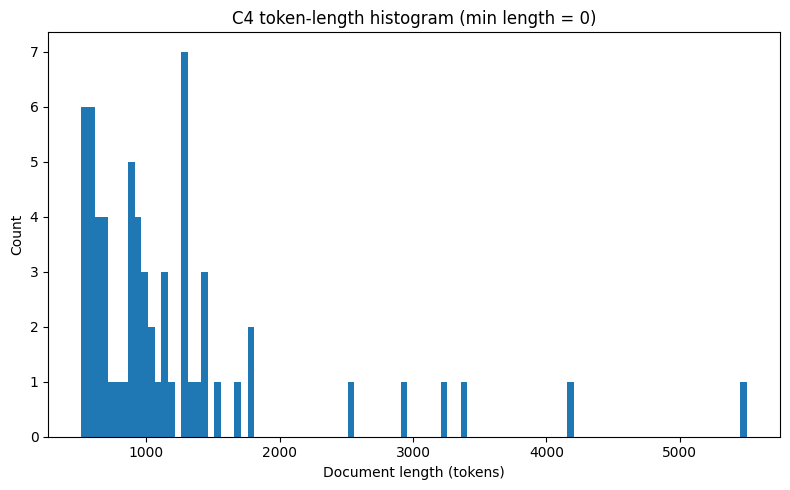

In [33]:
plot_token_length_hist("../data_long_ctx", tok)